# IBB Intermediate Checkpoint

#### Requirements

```
pip install matplotlib --user
pip install opencv-python --user
pip install numpy --user
pip install scipy --user
pip install scikit-learn --user
```

In [27]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial

# Reading all images and saving them
image_list = []
dim = (128,128)

for folder_number in range(1,101):
    folder_name = f'{folder_number:03d}'
    
    for image_number in range(1,11):
        image_name = f'{image_number:02d}'
        # image = cv2.imread("../awe/"+folder_name+"/"+image_name+".png")

        # If in Faculty computers 
        path = os.path.join(os.getcwd(), "awe", folder_name, image_name)
        image = cv2.imread(path+".png")
        # print(image, folder_name, image_name, path+".png", os.getcwd())

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        image_list.append(np.array(image))
  
# Now, the variable 'image_list[x]' stores the pixel values of image

In [8]:
image_list_by_class = [image_list[i:i+10] for i in range(0, len(image_list), 10)]

In [9]:
# Converting 2D image into a 1D vector for baseline
image_vector_list = []

for image in image_list:
    image_vector_list.append(np.ravel(image))


#### Utility functions

In [12]:
def build_matrix_from_list(list):
    dim = int(math.sqrt(len(list)))
    list = np.array(list)
    matrix = []

    while list.size != 0:
        matrix.append(list[:dim])
        list = list[dim:]
    
    return matrix

In [13]:
def show_feature_vector(feature_vector):
    # x = np.array(feature_vector)
    # dim = int(math.sqrt(len(feature_vector)))
    matrix = build_matrix_from_list(feature_vector)

    image = np.array(matrix, copy=False) / 255.0
    plt.imshow(image) 
    plt.axis('off')
    plt.show()

### LBP feature extractors

In [10]:
# Baseline LBP 

# Receives an image vector and the dimension of the LBP local window 
# Returns the image feature vector
def baselineLBP(image, dimLBP):
    radius = int((dimLBP - 1)/2)
    matrix_divided = []
    matrixLBP = []
    feature_vector = []
    
    # Add padding to a picture that is not divisible by the dimension of the LBP feature extraction matrix
    numberOfPadding = dimLBP - (image.shape[0] % dimLBP)
    image = cv2.copyMakeBorder(image, 0, numberOfPadding, 0, numberOfPadding, cv2.BORDER_CONSTANT, 0) 
    
    for width in range(radius, image.shape[0], dimLBP):
        for height in range(radius, image.shape[1], dimLBP):

            # Builds LBP feature extraction matrix
            m = [[image[width-radius][height-radius], image[width][height-radius], image[width+radius][height-radius]],
                        [image[width-radius][height], image[width][height], image[width+radius][height]],
                        [image[width-radius][height+radius], image[width][height+radius], image[width+radius][height+radius]]]
            matrix_divided.append(m)
            
            # Converts values in the extraction matrix to binary (if element < central element then 0 else 1)
            m2 = [[0 if m[row][element] < m[1][1] else 1 for element in range(0, 3)] for row in range(0, 3)] 
            matrixLBP.append(m2)
            
            # Building the LBP values (clockwise) and add them to the feature vector
            value = 1*m2[0][0] + 2*m2[0][1] + 4*m2[0][2] + 8*m2[1][2] + 16*m2[2][2] + 32*m2[2][1] + 64*m2[2][0] + 128*m2[1][0]
            feature_vector.append(value)
    
    return feature_vector

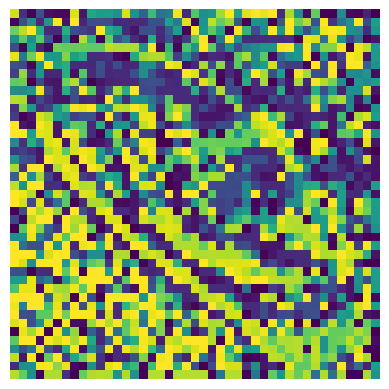

In [14]:
result = baselineLBP(image_list[0], 3)
show_feature_vector(result)

# cosine_similarity(image_list[0].ravel(), result)

In [15]:
# Overlapping LBP 

# Receives an image vector and the dimension of the LBP local window 
# Returns the [image feature vector, binary
def overlappingLBP(image, dimLBP):
    radius = int((dimLBP - 1)/2)
    matrix_divided = []
    matrixLBP = []
    feature_vector = []
    
    # Add padding to a picture that is not divisible by the dimension of the LBP feature extraction matrix
    numberOfPadding = dimLBP - (image.shape[0] % dimLBP)
    image = cv2.copyMakeBorder(image, 0, numberOfPadding, 0, numberOfPadding, cv2.BORDER_CONSTANT, 0) 
    
    # Changing the step of the for loops from the dimention of the LBP window to 1 makes the LBP window overlap
    for width in range(radius, image.shape[0]-(radius+1), 1):
        for height in range(radius, image.shape[1]-(radius+1), 1):
            
            # Builds LBP feature extraction matrix
            m = [[image[width-radius][height-radius], image[width][height-radius], image[width+radius][height-radius]],
                        [image[width-radius][height], image[width][height], image[width+radius][height]],
                        [image[width-radius][height+radius], image[width][height+radius], image[width+radius][height+radius]]]
            matrix_divided.append(m)
            
            # Converts values in the extraction matrix to binary (if element < central element then 0 else 1)
            m2 = [[0 if m[row][element] < m[1][1] else 1 for element in range(0, 3)] for row in range(0, 3)] 
            matrixLBP.append(m2)
            
            # Building the LBP values (clockwise) and add them to the feature vector
            value = 1*m2[0][0] + 2*m2[0][1] + 4*m2[0][2] + 8*m2[1][2] + 16*m2[2][2] + 32*m2[2][1] + 64*m2[2][0] + 128*m2[1][0]
            feature_vector.append(value)
    
    return feature_vector

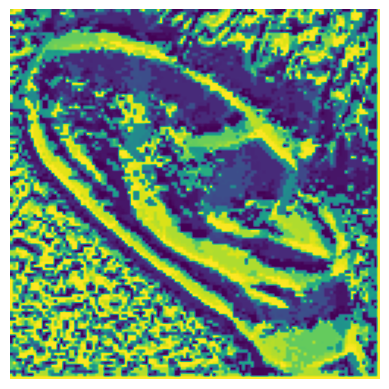

In [16]:
result = overlappingLBP(image_list[0], 7)
show_feature_vector(result)

In [17]:
# Uniform LBP 

# Receives an image vector and the dimension of the LBP local window 
# Returns the uniform image feature vector
def uniformLBP(image, dimLBP):
    radius = int((dimLBP - 1)/2)
    matrix_divided = []
    matrixLBP = []
    feature_vector = []
    
    # Add padding to a picture that is not divisible by the dimension of the LBP feature extraction matrix
    numberOfPadding = dimLBP - (image.shape[0] % dimLBP)
    image = cv2.copyMakeBorder(image, 0, numberOfPadding, 0, numberOfPadding, cv2.BORDER_CONSTANT, 0) 
    
    for width in range(radius, image.shape[0], dimLBP):
        for height in range(radius, image.shape[1], dimLBP):
            
            # Builds LBP feature extraction matrix
            m = [[image[width-radius][height-radius], image[width][height-radius], image[width+radius][height-radius]],
                        [image[width-radius][height], image[width][height], image[width+radius][height]],
                        [image[width-radius][height+radius], image[width][height+radius], image[width+radius][height+radius]]]
            matrix_divided.append(m)
            
            # Converts values in the extraction matrix to binary (if element < central element then 0 else 1)
            m2 = [[0 if m[row][element] < m[1][1] else 1 for element in range(0, 3)] for row in range(0, 3)] 
            matrixLBP.append(m2)
            
            # Build uniform binary list (clockwise)
            uniform_binary_list = [m2[0][0], m2[0][1], m2[0][2], m2[1][2], m2[2][2], m2[2][1], m2[2][0], m2[1][0]]
            
            # uniform_binary_list = 
            uniform_binary_list.sort(reverse=False) 
            
            # Building the LBP values (clockwise) and add them to the feature vector            
            value = 1*uniform_binary_list[0] + 2*uniform_binary_list[1] + 4*uniform_binary_list[2] + 8*uniform_binary_list[3] + 16*uniform_binary_list[4] + 32*uniform_binary_list[5] + 64*uniform_binary_list[6] + 128*uniform_binary_list[7]
            feature_vector.append(value)
    
    return feature_vector

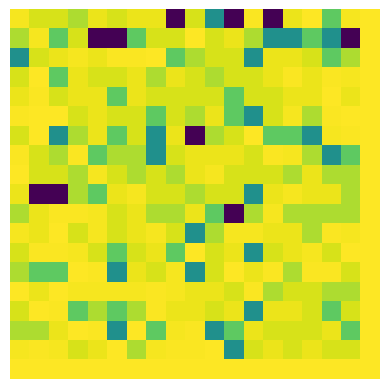

In [18]:
result = uniformLBP(image_list[0], 7)
show_feature_vector(result)

### Rank-1

In [62]:
# Returns a list of siye 100 with the flattened images
def precompute_all_averages_pixel_by_pixel():
    all_averages_pre_computed = [np.ravel(np.mean(image_list_by_class[i], axis=0)) for i in range(len(image_list_by_class))]
    return np.array(all_averages_pre_computed)

In [60]:
# Returns a flattened 128x128 matrix
def compute_average_of_class_pixel_by_pixel(class_number, image_index_to_remove):
    image_list_processed = np.delete(image_list_by_class[class_number], image_index_to_remove, axis=0)
    updated_average = np.mean(image_list_processed, axis=0)
    return np.ravel(updated_average)

In [81]:
# Rank-1 function for a chosen image - works for every LBP, we just need to pass the corresponding functions as arguments
# chosen_image_index between [0, 1000[
def rank_one(chosen_image_index, func_precompute_averages, func_average):
    class_index = math.floor(chosen_image_index / 10) # class_index between [0, 100[
    chosen_image_index_processed = (chosen_image_index % 10) # chosen_image_index_processed between [0, 10[

    # Computing all averages and then replacing the average[class_index] by the average of that class without the chosen image
    all_averages_pre_computed = func_precompute_averages()
    all_averages_pre_computed[class_index] = func_average(class_index, chosen_image_index_processed)

    # Using cosine similarity as a similarity metric
    cosine_similarity_list = cosine_similarity([np.ravel(image_list[chosen_image_index])], all_averages_pre_computed)

    # Finding class with highest similarity
    max_similarity = np.max(cosine_similarity_list)
    index = np.where(cosine_similarity_list == max_similarity)[1][0]
    print(index)

    # If the class with the highest similarity has the same class as the chosen image for comparison
    # Then we return 1
    # Else we return 0
    if index == class_index:
        return 1
    else:
        return 0

In [83]:
# def rank_one_for_all_images():


# print(len(rank_one(0, precompute_all_averages_pixel_by_pixel, compute_average_of_class_pixel_by_pixel)))

# rank_one(0, precompute_all_averages_pixel_by_pixel, compute_average_of_class_pixel_by_pixel)


76
Test:  0
0


### Utility functions

In [ ]:
def cosine_similarity(list_1, list_2):
    result = 1 - spatial.distance.cosine(list_1, list_2)
    return result


In [ ]:
def buildUniformLBPFeatureVector(binary_vector):
    feature_vector = []
    #cars.sort(reverse=True) 
    
    for m in binary_matrix_list:
        # Building the LBP values (clockwise) and add them to the feature vector
        value = 1*m[0][0] + 2*m[0][1] + 4*m[0][2] + 8*m[1][2] + 16*m[2][2] + 32*m[2][1] + 64*m[2][0] + 128*m[1][0]
        feature_vector.append(value)
        
    return feature_vector

In [ ]:
def buildLBPFeatureVector(binary_matrix_list):
    feature_vector = []
    # binary_matrix_list.flatten()
    for m in binary_matrix_list:
        # fm = flattenLBPMatrix(m)
        
        
        # Building the LBP values (clockwise) and add them to the feature vector
        value = 1*fm[0] + 2*m[0][1] + 4*m[0][2] + 8*m[1][2] + 16*m[2][2] + 32*m[2][1] + 64*m[2][0] + 128*m[1][0]
        feature_vector.append(value)
        
    return feature_vector

In [ ]:
# Deleting the central one but not flattening clockwise yet
def flattenLBPMatrix(matrix):
    dimension = len(matrix[0])
    center_coord = int((dimension-1)/2)
    flattened_list = []
    
    for row in range(0, dimension):
        for column in range(0, dimension):
            flattened_list.append(matrix[row][column])
            
    central_element = int((len(flattened_list) - len(flattened_list) % 2)/2)
    flattened_list.pop(central_element)
    
    return flattened_list